In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os, sys, shutil, time 


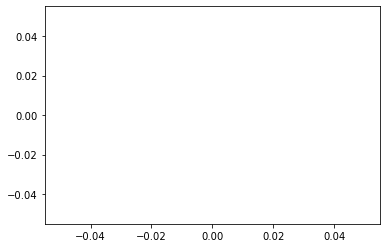

In [2]:
plt.plot()
plt.show()

In [3]:
trainimagePath='yolo_model/dataset/images/train'
trainlabelPath='yolo_model/dataset/labels/train/FASTER-RCNN'
valimagePath='yolo_model/dataset/images/val'
vallabelPath='yolo_model/dataset/labels/val/FASTER-RCNN'

label_txt = []
delete = []

print("Train Image:" + str(len(os.listdir(trainimagePath))))
print("Train Label:" +str(len(os.listdir(trainlabelPath))))
for filename in os.listdir(trainlabelPath):
    word = filename[:-4]
    label_txt.append(word)
for file in os.listdir(trainimagePath):
    if file[:-4] not in label_txt:
        delete.append(file)
print(delete)
print(len(delete))

Train Image:170
Train Label:170
[]
0


In [4]:
label_txt = []
delete = []
print("Val Image:" +str(len(os.listdir(valimagePath))))
print("Val Label:" +str(len(os.listdir(vallabelPath))))
for filename in os.listdir(vallabelPath):
    word = filename[:-4]
    label_txt.append(word)
for file in os.listdir(valimagePath):
    if file[:-4] not in label_txt:
        delete.append(file)
print(delete)
print(len(delete))

Val Image:168
Val Label:168
[]
0


In [5]:
from glob import glob
import xml.etree.ElementTree as ET
from matplotlib import patches

In [9]:
df = []
cnt = 0
annotations = glob('./yolo_model/dataset/labels/train/FASTER-RCNN/*.xml')
for file in annotations:
    filename = file.split('\\')[-1]
    filename =filename.split('.')[0] + '.jpg'
    row = []
    parsedXML = ET.parse(file)
    for node in parsedXML.getroot().iter('object'):
        file_class = node.find('name').text
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)

        row = [filename, file_class, xmin, xmax, ymin, ymax]
        df.append(row)
        cnt += 1
data = pd.DataFrame(df, columns=['filename', 'class', 'xmin', 'xmax', 'ymin', 'ymax'])

data[['filename', 'class', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('train.csv', index=False)

In [10]:
df = []
cnt = 0
annotations = glob('./yolo_model/dataset/labels/val/FASTER-RCNN/*.xml')
for file in annotations:
    filename = file.split('\\')[-1]
    filename =filename.split('.')[0] + '.jpg'
    row = []
    parsedXML = ET.parse(file)
    for node in parsedXML.getroot().iter('object'):
        file_class = node.find('name').text
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)

        row = [filename, file_class, xmin, xmax, ymin, ymax]
        df.append(row)
        cnt += 1
data2 = pd.DataFrame(df, columns=['filename', 'class', 'xmin', 'xmax', 'ymin', 'ymax'])

data2[['filename', 'class', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('test.csv', index=False)

Image size is (2736, 3648, 3)


<Figure size 432x288 with 0 Axes>

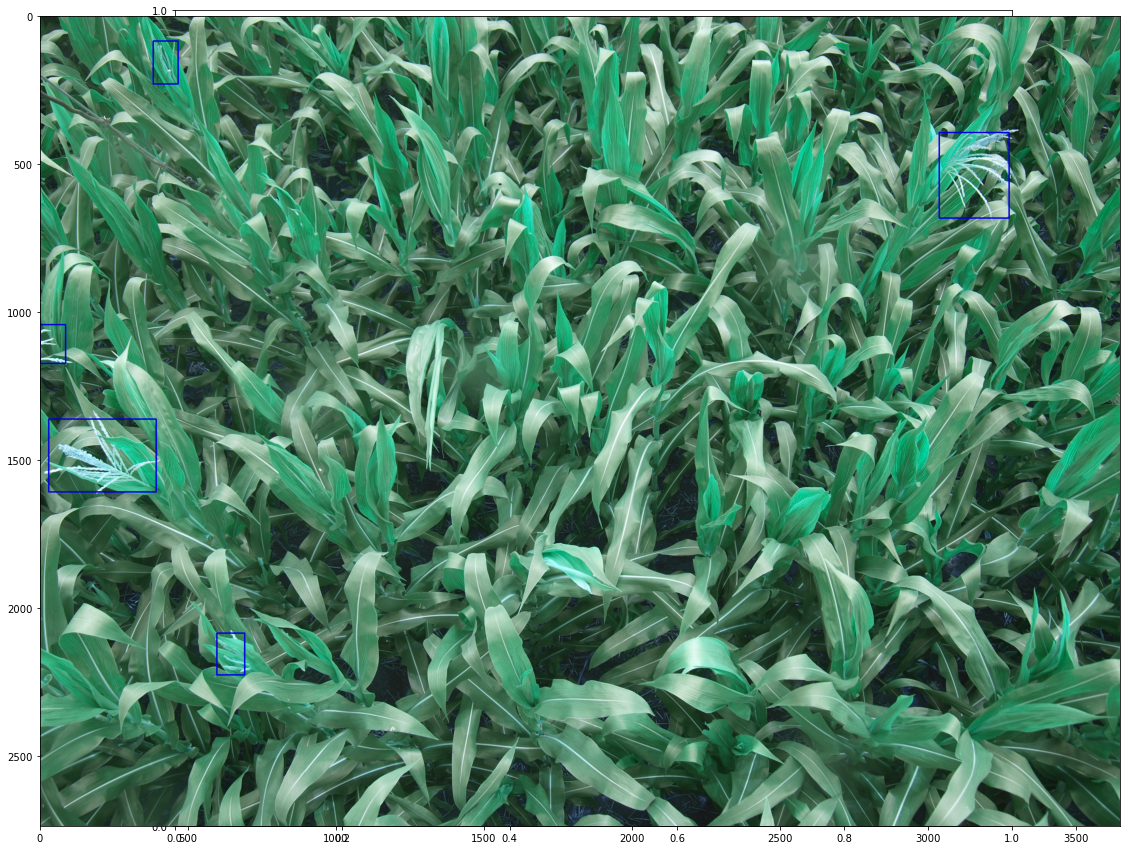

In [16]:
fig = plt.figure()
fig, ax = plt.subplots(1, figsize=(15, 15))
ax = fig.add_axes([0,0,1,1])
#plot a picture
pic_name = 'T0001_XM_20110809100243_02.jpg' 
image = cv2.imread('yolo_model/dataset/images/train/T0001_XM_20110809100243_02.jpg')
print(f'Image size is {image.shape}')
for _,row in data[data.filename == pic_name].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax


    image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), color=(0,0,225 ), thickness=3)
    plt.imshow(image)

In [17]:
import torch
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import  FastRCNNPredictor

from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from engine import train_one_epoch, evaluate

In [31]:
print(len(data['filename'].unique()))
print(len(data2['filename'].unique()))

170
168


In [32]:
device= torch.device("cpu")

In [33]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 

In [34]:
class MaizeData(Dataset):

    def __init__(self, dataframe, image_dir, transforms= None):
        super().__init__()

        self.df = dataframe
        self.image_dir = image_dir
        self.image_ids = dataframe['filename'].unique()
        print(f'self.image_ids is {self.image_ids.shape}')
        print('new dir is',self.image_dir)
        self.transforms = transforms

    def __getitem__(self, index: int):
        # print(f'index is {index} and image_id is {self.image_ids[index]}')
        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]

        # read image into cv2 format
        # image = Image.open(os.path.join(self.image_dir, image)).convert("RGB")
        
        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.IMREAD_COLOR)#Image.open
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=  255.
        # print(f'image_dir is {self.image_dir}')#, image shape is {image.shape}, \n ')
       

        # find are based on xmin, ymin, xman, and yman
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # print(f'boxes is {boxes}')
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        # print(f'area is {area}')

        # conver boxes and are into tensors
        
        # boxes = torch.as_tensor(boxes, dtype= torch.float32)
        
        area  = torch.as_tensor(area, dtype=torch.float32)

        # there is one class only
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        # print('here')
        labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
       

        # create a dictionary target
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        # print('there')

        # # transforms
        if self.transforms is not None:
            # image = self.transforms(image)
            sample = {'image': image,
                      'bboxes': target['boxes'],
                      'labels': labels
                      }
            sample = self.transforms(**sample)
            image = sample['image']
        
        # zip boxes, map as tensor, create tuple and stack
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]
        # return 10 # returns only 10 images - use it for overfitting the model

In [35]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)], # P(prob/apply aug) = 0.1, numpy HWC -> tensor CHW
    bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)], 
    bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [36]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property # decorator same as property method
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total /self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [37]:
batch_size = 10
img_size = 100
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# collate function
# each element of dataset returns tupe(image, target) instead of a single value

def collate_function(batch):
    return tuple(zip(*batch))

# def get_transform(train):
#     transforms = []
#     # transforms.append(T.Resize(img_size)) # resize to avoid insufficient memory
#     # transforms.append(T.CenterCrop(img_size))
#     # conver PIL to Tensor
#     transforms.append(T.ToTensor())
#     if train:
#         # flip images during training 
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     return T.Compose(transforms)

# train and test datasets
train_dataset = MaizeData(data, trainimagePath, get_train_transform() )
test_dataset  = MaizeData(data2, valimagePath, get_test_transform() )




#train and test dataloader
train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers =0,
                               collate_fn = collate_function)

test_data_loader = DataLoader(test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers =0,
                               collate_fn = collate_function)

self.image_ids is (170,)
new dir is yolo_model/dataset/images/train
self.image_ids is (168,)
new dir is yolo_model/dataset/images/val


In [38]:
for images, targets in train_data_loader:
    break
print(f"image_0 is {images[0].shape}")
print(f'targets_0 are {targets[0]}')


image_0 is torch.Size([3, 2736, 3648])
targets_0 are {'boxes': tensor([[3017.0000, 1650.0000, 3088.0000, 1724.0000]], dtype=torch.float64), 'labels': tensor([1]), 'image_id': tensor([22]), 'area': tensor([5254.]), 'iscrowd': tensor([0])}


img has shape of (2736, 3648, 3)
boxes is [[3287   24 3456  209]
 [3566  333 3648  529]
 [3303  285 3477  532]
 [3134  328 3238  537]
 [3249  604 3362  806]
 [3491  671 3617  830]
 [3246 1034 3367 1270]
 [3080 1055 3206 1268]
 [2879  115 3013  277]
 [2685   59 2768  169]
 [2747  193 2852  341]
 [2379   35 2508  172]
 [2508  336 2641  473]
 [3037  636 3166  846]
 [2884  733 2981  867]
 [2803  937 2986 1037]
 [2656  722 2779  841]
 [2457  686 2612  873]
 [2594  948 2696 1085]
 [2403  991 2554 1133]
 [2051  164 2199  336]
 [1476   78 1587  252]
 [1436  618 1592  790]
 [1745  685 1885  835]
 [1944  679 2067  811]
 [1976 1284 2078 1472]
 [2140 1359 2250 1525]
 [2304 1370 2390 1517]
 [2462 1934 2680 2191]
 [1458 1278 1858 1563]
 [1694 2023 1788 2119]
 [1717 2358 1846 2600]
 [2997 1875 3238 2066]
 [3276 2538 3475 2708]
 [3528 2536 3648 2710]
 [1144 2205 1254 2409]
 [ 883 2267 1066 2458]
 [ 122 2141  292 2302]
 [ 450 1902  714 2136]
 [ 364 1158  581 1279]
 [ 445 1376  721 1612]
 [ 827 1322 116

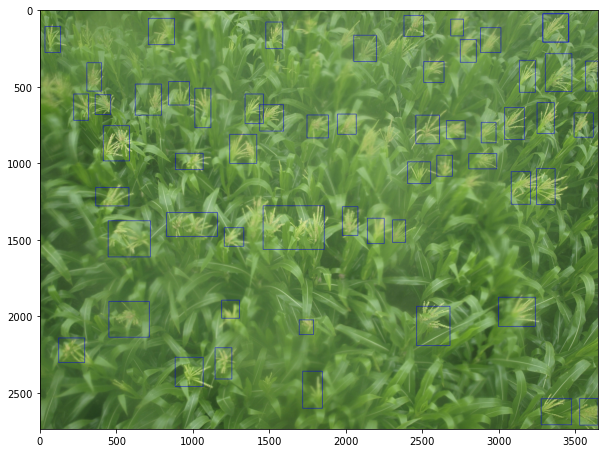

In [40]:
# let's see some images
# read first batch from train_data_loader
images, targets = next(iter(train_data_loader))

#send image to device
images = list(image.to(device) for image in images)

# targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
targets = [{k: v.long().to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
xmin, ymin, xmax, ymax = boxes[0][0], boxes[0][1],boxes[0][2], boxes[0][3]

sample_tr = images[0].permute(1, 2, 0).cpu().numpy() # permute rearrange to 1,2,0 axis

# de-normalize
sample_tr = sample_tr *  255.

print(f"img has shape of {sample_tr.shape}")
print(f"boxes is {boxes}")
print(f"dimension of boxeses  are {xmin}, {ymin}, {xmax}, {ymax}")


fig, ax = plt.subplots(1, 1, figsize=(10,8))

for box in boxes:
    cv2.rectangle(sample_tr,
                 (box[0], box[1]),
                 (box[2], box[3]), 
                # (5, 40), (81, 95),
                  color=(0, 0, 225),
                  thickness=2)

# for i in range(len(boxes)):
#     cv2.rectangle(sample_tr, 
#                   (boxes[i][0], boxes[i][1]),
#                   (boxes[i][2], boxes[i][3]),
#                   (0, 0 , 225), 3)


# ax.set_axis_off()
# ax.imshow(sample_tr)  #works but no bounding boxes


sample_tr = cv2.rectangle(sample_tr, (xmin,ymin), (xmax, ymax), color=(0,0,225 ), thickness=3)
plt.imshow((sample_tr).astype(np.uint8)); # blank screen - nothing display

In [41]:
#Fine Tuning Pre-Trained Model
#load a pre-trained model with resnet50 as backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one
num_classes = 2 # 1 class(maize) and 0(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head wit the new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [50]:
# Training parameters
num_epochs = 1 #100
learning_rate = 1e-4
loss_hist = Averager()

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params=params, lr =learning_rate, momentum = 0.9, weight_decay= 0.005)
# lr_scheduler = None

# USE ADAM
# optimizer = torch.optim.Adam(params= params, lr = learning_rate)

start_time = time.time()
total_train_loss = []

for epoch in range(num_epochs):
    loss_hist.reset()
    star_time = time.time()
    train_loss = []
    model.train()

    for images, targets in train_data_loader:
        
        #send images and targets to device
        images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
        targets = [{k: v.long().to(device) for k,v in t.items()} for t in targets]

        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        # print(f'diff losses are {loss_dict.keys()} ')
        train_loss.append(losses.item())
        # print(f"train losss is {train_loss}")
        loss_hist.send(losses.item())

        optimizer.zero_grad() # to clear old gradient to zero
        losses.backward() # back prop for required_grade = True
        optimizer.step() # update parameter based on parameter.grad

    epoch_train_loss = np.mean(train_loss)
    # print(f"Epoch_train_loss is {epoch_train_loss}")
    total_train_loss.append(epoch_train_loss)
        
        #     print(f'Iterattion #{iter}  loss: {loss_value}')

        # itr += 1
        # if lr_scheduler is not None:
        #     lr_scheduler.step() # for adjusting the learning rate

    # print(f'Epoch #{epoch+1} loss: {epoch_train_loss}')
    print(f'Epoch #{epoch+1} loss: {loss_hist.value}')


    evaluate(model, test_data_loader, device=device )

# save check points at every epochs

end_time = time.time()
print(f"\n Total training time is {end_time - start_time} seconds \n")
# save model    
torch.save(model.state_dict(),  "faster_rcnn.pth")
torch.save(model, 'faster_rcnn.pt')

Epoch #1 loss: 1.3001867111991434
creating index...
index created!
Test:  [ 0/17]  eta: 0:13:35  model_time: 45.9642 (45.9642)  evaluator_time: 0.2858 (0.2858)  time: 47.9654  data: 1.6934
Test:  [16/17]  eta: 0:00:49  model_time: 45.9653 (47.0790)  evaluator_time: 0.4140 (0.5050)  time: 49.3232  data: 1.6613
Test: Total time: 0:13:58 (49.3258 s / it)
Averaged stats: model_time: 45.9653 (47.0790)  evaluator_time: 0.4140 (0.5050)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.154
 Average Recall   

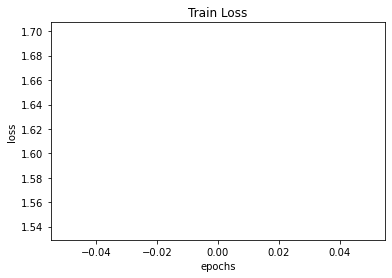

In [43]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

nms_out is [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
outputs is [{'boxes': tensor([[7.8080e+02, 6.6403e+02, 9.2761e+02, 9.3717e+02],
        [5.8542e+02, 2.0882e+03, 7.2142e+02, 2.2678e+03],
        [9.6916e+02, 2.2874e+03, 1.0871e+03, 2.4243e+03],
        [3.4798e+03, 9.0997e+01, 3.6409e+03, 3.3751e+02],
        [1.5033e+03, 0.0000e+00, 1.5843e+03, 1.7286e+02],
        [1.8371e+03, 3.7726e+02, 1.9129e+03, 5.3199e+02],
        [9.0221e+01, 2.2683e+03, 2.3200e+02, 2.3971e+03],
        [2.1574e+03, 3.8006e+02, 2.2516e+03, 5.9320e+02],
        [3.5326e+03, 1.0671e+02, 3.6477e+03, 2.9445e+02],
        [2.6127e+03, 2.3625e+01, 2.7271e+03, 1.6435e+02],
        [2.3497e+03, 4.2797e+02, 2.4406e+03, 6.0597e+02],
        [4.0936e+01, 1.

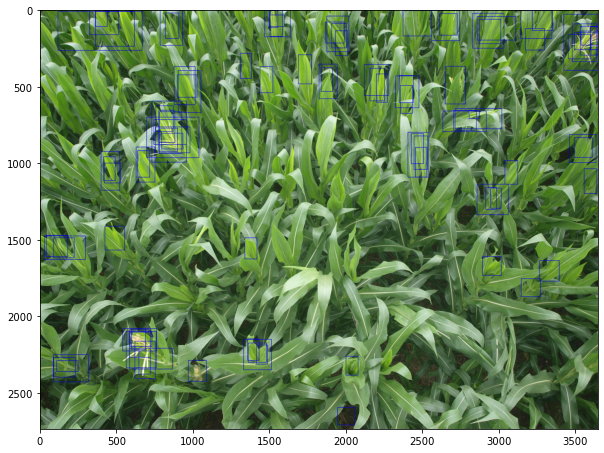

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Validation of model 
model = torch.load('faster_rcnn.pt')
images_val, targets  = next(iter(test_data_loader)) # test_data_loader

images_val = list(img.to(device) for img in images_val)
# targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
# print(f"target is {targets}")
# boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample_val = images_val[0].permute(1, 2, 0).cpu().numpy() # permute re-arrange the axes
sample_val = sample_val * 255. # de-normalize 

#get the bounding box from model
model.eval()
cpu_device = torch.device('cpu')

outputs = []
outputs = model(images_val)

# NMS 
nms_out = (torchvision.ops.nms(boxes= outputs[0]['boxes'], scores= outputs[0]['scores'], iou_threshold= 0.5)).cpu().numpy()
print(f"nms_out is {nms_out}")

outputs = [{k: v.to(cpu_device) for k,v in t.items()} for t in outputs]
print(f"outputs is {outputs}")
outs_val = outputs[nms_out[0]]['boxes'].cpu().detach().numpy().astype(np.int32)
# outs_val = outs_val[nms_out[0]]


for box in outs_val:
    print(f"box is {box}")
    cv2.rectangle(sample_val,
                #   (box, box),
                #   (box[2], box[3]),
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 225),
                  2
                  )


# image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)

plt.imshow((sample_val).astype(np.uint8))